# Spotted star

This is a simple example of how one might go about modeling rotational light curves of spotted stars.

**NOTE: The next version of `starry` will likely implement this in a more user-friendly fashion. This notebook mostly showcases how if you're willing to put a little work in, you can use `starry` to do things beyond simple exoplanet mapping!**

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm

In [2]:
%matplotlib inline

## Creating a map with a starspot

Let's create a 25th order map with a starspot at latitude 30$^\circ$ N and longitude 30$^\circ$ E:

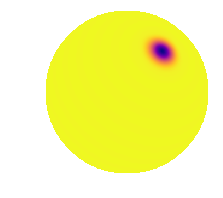

In [3]:
lmax = 25
star = starry.Map(lmax)
star.axis = [0, 1, 0]
star[0,0] = 1
star.add_gaussian(sigma=0.1, amp=-1, lat=30, lon=30)
star.show()

We can add additional spots to the map if we'd like:

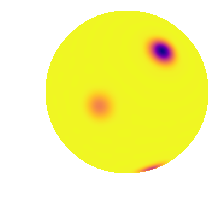

In [4]:
star.add_gaussian(sigma=0.1, amp=-0.3, lat=-10, lon=-20)
star.add_gaussian(sigma=0.1, amp=-0.5, lat=-70, lon=60)
star.show()

If stars didn't rotate differentially, computing this star's rotational light curve would be cake. Let's give it a rotation period of 1 day and see what it looks like:

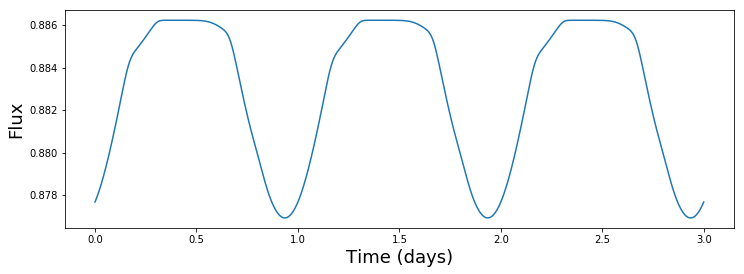

In [5]:
time = np.linspace(0, 3, 1000)
P = 1.
theta = 360 / P * time
flux = star.flux(theta=theta)
fig, ax = pl.subplots(1, figsize=(12, 4))
pl.plot(time, flux)
pl.xlabel('Time (days)', fontsize=18);
pl.ylabel('Flux', fontsize=18);

## Differential rotation

In reality, starspots at different latitudes should rotate at different rates. We can simulate this by generating different `starry` maps for each starspot, and adding the light curves together.

Let's generate a few spots of random sizes, amplitudes, and location on the star.

In [6]:
nspots = 5
sigma = [0.1, 0.1, 0.2, 0.3, 0.1]
amp = [-0.1, -0.2, -0.01, -0.05, -0.1]
lat = np.array([0, 30, -20, 45, -60])
lon = np.array([30, 60, 120, -30, -45])
spot = [starry.Map(lmax) for n in range(nspots)]
for n in range(nspots):
    spot[n].axis = [0, 1, 0]
    spot[n].add_gaussian(sigma=sigma[n], amp=amp[n], lat=lat[n], lon=lon[n])

We can visualize what the star looks like at time $t = 0$ by adding the maps:

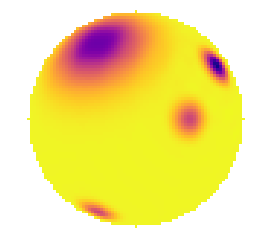

In [7]:
x, y = np.meshgrid(np.linspace(-1, 1, 75), np.linspace(-1, 1, 75))
img = np.zeros_like(x)
for n in range(nspots):
    img += np.array([spot[n].evaluate(x=x[j], y=y[j]) for j in range(75)])
pl.imshow(img, cmap='plasma', origin='lower');
pl.gca().axis('off');

That's a crazy looking star. For simplicity, let's give each of the spots a rotation period proportional to the latitude:

In [8]:
P = 1 + np.abs(lat * np.pi / 180)
print(P)

[1.         1.52359878 1.34906585 1.78539816 2.04719755]


Let's compute the light curve over the span of 10 days:

100%|██████████| 16/16 [00:02<00:00,  7.75it/s]


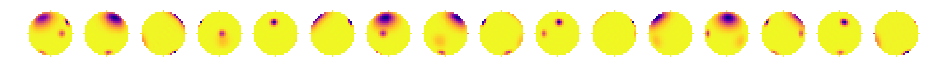

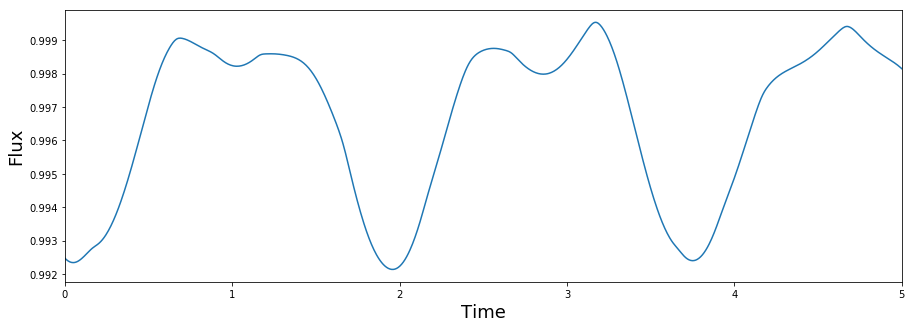

In [9]:
# The angular position of the spots over time
time = np.linspace(0, 5, 1000)
theta = [360 / P[n] * time for n in range(nspots)]

# Plot the map
nimg = 16
res = 25
fig, ax = pl.subplots(1, nimg, figsize=(nimg, 1))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for k, i in tqdm(enumerate(np.linspace(0, 1000, nimg, endpoint=False)), total=16):
    img = np.zeros_like(x)
    for n in range(nspots):
        img += np.array([spot[n].evaluate(theta=theta[n][int(i)], x=x[j], y=y[j]) for j in range(res)])
    img -= np.nanmin(img)
    img /= np.nanmax(img)
    ax[k].imshow(img, cmap='plasma', origin='lower', vmax=1., vmin=0.);
    ax[k].axis('off');

# Plot the combined light curve
lc = 1 + np.sum([spot[n].flux(theta=theta[n]) for n in range(nspots)], axis=0)
fig, ax = pl.subplots(1, figsize=(15, 5))
ax.plot(time, lc);
ax.set_xlim(0,5)
ax.set_ylabel("Flux", fontsize=18);
ax.set_xlabel("Time", fontsize=18);

## Transits of spots

Let's now look at some spot transits. Let's start simple, with `spot[3]` (the really big one):

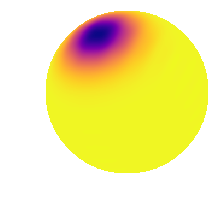

In [10]:
star = spot[3]
star.show()

Now let's compute the transit light curve of a planet with $r = 0.1$ transiting along the $x$ axis at $y = 0.9$ (right through the middle of the spot):

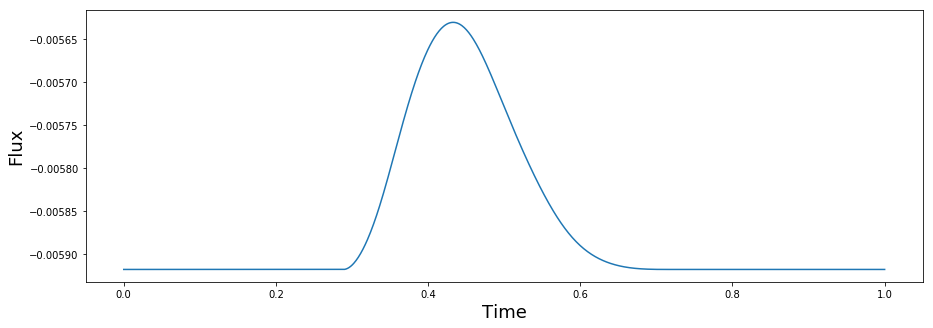

In [11]:
fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), star.flux(ro=0.1, xo=np.linspace(-1.5, 1.5, 1000), yo=0.9));
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

That doesn't look right! It turns out that we never set a baseline for our map when we created it a while back: we simply added a gaussian with negative amplitude, which means the spot actually has *negative* flux. We can verify this by checking if the map is *positive semi-definite*:

In [12]:
star.psd()

False

The `psd()` method runs a nonlinear optimizer to find the global minimum of the map and returns `False` if the minimum is negative. Let's therefore add a little bit of power to the $l = 0, m = 0$ harmonic so that the mean stellar flux is positive:

In [13]:
star[0, 0] = 0.1
star.psd()

True

The map is now non-negative everywhere. Finally, let's re-compute the transit light curve. For reference, let's also compute the light curve of a star without the spot:

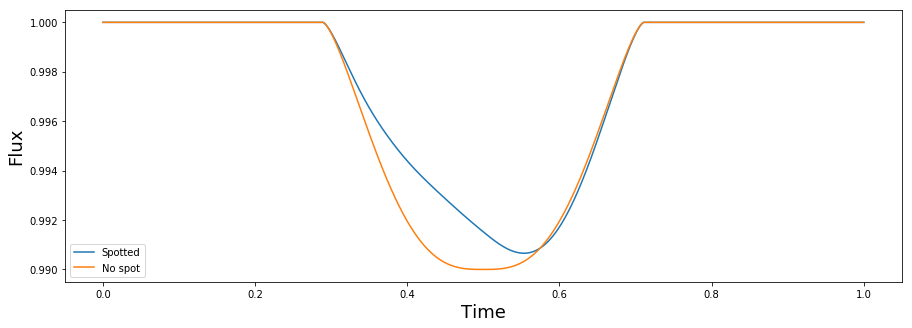

In [14]:
# Flux w/ spot
flux_spot = star.flux(ro=0.1, xo=np.linspace(-1.5,1.5,1000), yo=0.9)
flux_spot /= flux_spot[0]

# Flux w/ no spot
star_nospot = starry.Map(lmax)
star_nospot[0, 0] = 0.1
flux_nospot = star_nospot.flux(ro=0.1, xo=np.linspace(-1.5, 1.5, 1000), yo=0.9)
flux_nospot /= flux_nospot[0]

fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), flux_spot, label='Spotted');
pl.plot(np.linspace(0, 1, 1000), flux_nospot, label='No spot');
pl.legend(loc='lower left');
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

Now we're talking! 

Lastly, just for fun, we can compute the transit light curve for the multi-spotted star from before. Let's sum up the maps for all the spots and feed them into a single map, just like before:

In [15]:
y = np.sum([spot[n].y for n in range(nspots)], axis=0)

In [16]:
star = starry.Map(lmax)
n = 0
for l in range(lmax + 1):
    for m in range(-l, l + 1):
        star[l,m] = y[n]
        n += 1
star[0,0] = 0.2

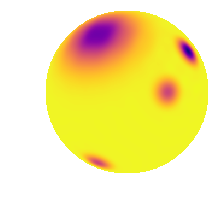

In [17]:
star.show()

Looks good. Let's change the transit parameters slightly to get a prettier light curve:

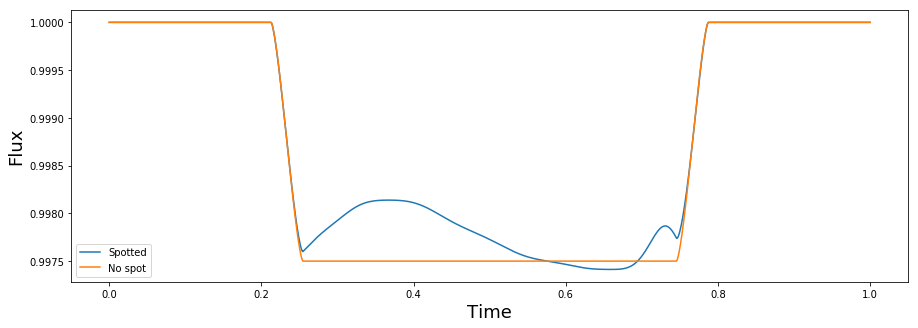

In [18]:
# Flux w/ spot
flux_spot = star.flux(ro=0.05, xo=np.linspace(-1.5,1.5,1000), yo=0.6)
flux_spot /= flux_spot[0]

# Flux w/ no spot
star_nospot = starry.Map(lmax)
star_nospot[0, 0] = 0.1
flux_nospot = star_nospot.flux(ro=0.05, xo=np.linspace(-1.5, 1.5, 1000), yo=0.6)
flux_nospot /= flux_nospot[0]

fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), flux_spot, label='Spotted');
pl.plot(np.linspace(0, 1, 1000), flux_nospot, label='No spot');
pl.legend(loc='lower left');
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

Two spot crossings are clearly visible!